# MinBits - Transformer for Stock Price Prediction

## Setup

In [ ]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import yfinance as yf
import matplotlib.pyplot as plt
import torch.nn.functional as F
from ta import add_all_ta_features
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import autocast, GradScaler

device = torch.device("cpu")

# Creating to directories where we store model and data
os.makedirs('stocks_data', exist_ok=True)
os.makedirs('trained_models', exist_ok=True)

## Data Fetch and Pre-processing

In [3]:
def store_stock_data(ticker, start_date, end_date, file_path):

    # Get historical market data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Reset the index to make the Date column a regular column
    data.reset_index(inplace=True)

    # Select the desired columns in the desired order
    columns = ['Date', 'High', 'Low', 'Open', 'Adj Close', 'Close', 'Volume']
    data = data[columns]

    # Make the above list as the actual header
    data.columns = columns

    data.to_csv(file_path, index=False, header=True)

In [4]:
def load_data_with_indicators(file_path, column='Close', time_step=100, train_fraction=0.8):
    # Load data
    df = pd.read_csv(file_path)
    # print("Initial columns in the dataset:", df.columns)

    # Ensure 'Date' column is in datetime format
    if 'Date' not in df.columns:
        raise KeyError("The dataset must contain a 'Date' column to create 'DayOfWeek' and 'Month' features.")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # print("/Converted 'Date' column:", df[['Date']].head())

    # Drop rows with invalid dates
    if df['Date'].isna().sum() > 0:
        # print("Dropping rows with invalid dates.")
        df.dropna(subset=['Date'], inplace=True)

    # Add 'DayOfWeek' and 'Month' columns
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    # print("Added 'DayOfWeek' and 'Month':", df[['Date', 'DayOfWeek', 'Month']].head())

    # Add technical indicators
    df = add_all_ta_features(
        df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )

    # Add lagged values
    for lag in range(1, 4):  # 3 previous days
        df[f"Close_lag_{lag}"] = df[column].shift(lag)

    # Drop NaN values caused by lagging
    df.dropna(inplace=True)

    # Define features and target
    features = ['High', 'Low', 'Open', 'Close', 'Volume', 'momentum_rsi', 'trend_macd',
                'volatility_bbh', 'volatility_bbl', 'Close_lag_1', 'Close_lag_2', 'DayOfWeek', 'Month']
    target = column

    # print("Final feature columns in DataFrame:", df.columns)  # Debug statement
    # print("Features to be selected:", features)  # Debug statement

    # Validate feature columns
    missing_features = [col for col in features if col not in df.columns]
    if missing_features:
        raise KeyError(f"The following features are missing from the DataFrame: {missing_features}")

    # Separate features and target
    X = df[features].values
    Y = df[target].values

    # Normalize features and target
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = feature_scaler.fit_transform(X)

    target_scaler = MinMaxScaler(feature_range=(0, 1))
    Y_scaled = target_scaler.fit_transform(Y.reshape(-1, 1))

    # Split into train and test sets
    training_size = int(len(X_scaled) * train_fraction)
    train_X, test_X = X_scaled[:training_size], X_scaled[training_size:]
    train_Y, test_Y = Y_scaled[:training_size], Y_scaled[training_size:]

    # Create sequences
    def create_sequences(dataset_X, dataset_Y, time_step):
        X, Y = [], []
        for i in range(len(dataset_X) - time_step):
            X.append(dataset_X[i:i + time_step])
            Y.append(dataset_Y[i + time_step])
        return np.array(X), np.array(Y)

    train_X, train_Y = create_sequences(train_X, train_Y, time_step)
    test_X, test_Y = create_sequences(test_X, test_Y, time_step)

    # Convert to PyTorch tensors
    train_X = torch.tensor(train_X, dtype=torch.float32)
    train_Y = torch.tensor(train_Y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32)
    test_Y = torch.tensor(test_Y, dtype=torch.float32)

    return train_X, train_Y, test_X, test_Y, feature_scaler, target_scaler

## Quantized Transformer Model

In [5]:
def quantize_tensor(tensor, bits):
    """
    Quantize the input tensor to a fixed-point representation with `bits` bits.
    The range is determined by the minimum and maximum values of the tensor.
    """
    if bits is None:
      # No Quantization
      return tensor

    eps = 1e-8  # Small positive value to avoid division by zero
    min_val, max_val = tensor.min(), tensor.max()
    scale = (max_val - min_val + eps) / (2 ** bits - 1)  # Compute scale based on the range
    zero_point = min_val

    # Quantize the tensor to integers
    quantized = torch.round((tensor - zero_point) / scale)

    # Return quantized tensor and scaling parameters for dequantization if needed
    return quantized * scale + zero_point

def quantize_tensor_weights(tensor, bits):
    """
    Quantize the weight tensor to a fixed-point representation with `bits` bits.
    The range is determined by the minimum and maximum values of the tensor.
    """

    if bits == 1:
      # Binarize
      return torch.where(tensor >= 0, 1, -1).type(tensor.dtype)

    eps = 1e-8  # Small positive value to avoid division by zero
    min_val, max_val = tensor.min(), tensor.max()
    scale = (max_val - min_val + eps) / (2 ** bits - 1)  # Compute scale based on the range
    zero_point = min_val

    # Quantize the tensor to integers
    quantized = torch.round((tensor - zero_point) / scale)

    # Return quantized tensor and scaling parameters for dequantization if needed
    return quantized * scale + zero_point

def quantize_layer_weights(layer, bits):
    """
    Quantize the weights of a given layer.
    """

    if bits is None:
      # No Quantization
      return layer

    for name, param in layer.named_parameters():
        if "weight" in name:
            param.data = quantize_tensor_weights(param.data, bits)
    return layer

In [6]:
class QuantizedCustomMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0, activation_bits = 8, weight_bits=8):
        super(QuantizedCustomMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.activation_bits = activation_bits
        self.weight_bits = weight_bits
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        # Linear layers for queries, keys, and values
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)

    def quantize_weights(self):
        """
        Quantize the weights of all layers within this module.
        """
        self.q_proj = quantize_layer_weights(self.q_proj, self.weight_bits)
        self.k_proj = quantize_layer_weights(self.k_proj, self.weight_bits)
        self.v_proj = quantize_layer_weights(self.v_proj, self.weight_bits)
        self.out_proj = quantize_layer_weights(self.out_proj, self.weight_bits)

    def forward(self, query, key, value):

        batch_size, seq_len, embed_dim = query.size()

        # Quantize input
        query = quantize_tensor(query, self.activation_bits)
        key = quantize_tensor(key, self.activation_bits)
        value = quantize_tensor(value, self.activation_bits)

        # Project queries, keys, and values
        Q = quantize_tensor(self.q_proj(query), self.activation_bits)
        K = quantize_tensor(self.k_proj(key), self.activation_bits)
        V = quantize_tensor(self.v_proj(value), self.activation_bits)

        # Split into multiple heads and reshape
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)
        attn_probs = F.softmax(attn_scores, dim=-1)  # Apply softmax
        attn_probs = self.dropout(attn_probs)  # Apply dropout

        # Attention output
        attn_output = torch.matmul(attn_probs, V)  # (batch_size, num_heads, seq_len, head_dim)

        # Concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)  # (batch_size, seq_len, embed_dim)
        output = quantize_tensor(self.out_proj(attn_output), self.activation_bits)  # Final linear projection with quantization
        return output


class QuantizedTransformerStockPredictor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, seq_len, activation_bits = 8, weight_bits=8):
        super(QuantizedTransformerStockPredictor, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.activation_bits = activation_bits
        self.weight_bits = weight_bits

        # Input layer
        self.input_layer = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, d_model))

        # Transformer encoder components
        self.self_attention_layers = nn.ModuleList([
            QuantizedCustomMultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout, activation_bits = self.activation_bits, weight_bits=self.weight_bits)
            for _ in range(num_encoder_layers)
        ])
        self.layer_norm1 = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_encoder_layers)])
        self.feedforward1 = nn.ModuleList([nn.Linear(d_model, dim_feedforward) for _ in range(num_encoder_layers)])
        self.activation = nn.ModuleList([nn.ReLU() for _ in range(num_encoder_layers)])
        self.feedforward2 = nn.ModuleList([nn.Linear(dim_feedforward, d_model) for _ in range(num_encoder_layers)])
        self.layer_norm2 = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_encoder_layers)])
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for _ in range(num_encoder_layers)])

        # Output layer
        self.output_layer = nn.Linear(d_model, 1)

    def quantize_weights(self):
        """
        Quantize the weights of all layers in the transformer.
        """
        self.input_layer = quantize_layer_weights(self.input_layer, self.weight_bits)
        self.output_layer = quantize_layer_weights(self.output_layer, self.weight_bits)

        for i in range(len(self.self_attention_layers)):
            self.self_attention_layers[i].quantize_weights()
            self.feedforward1[i] = quantize_layer_weights(self.feedforward1[i], self.weight_bits)
            self.feedforward2[i] = quantize_layer_weights(self.feedforward2[i], self.weight_bits)

    def forward(self, x):

        # Quantize layer weights before every forward pass
        self.quantize_weights()

        # Quantize the input to the model
        x = quantize_tensor(x, self.activation_bits)

        # Input layer
        x = quantize_tensor(self.input_layer(x), self.activation_bits) + quantize_tensor(self.positional_encoding, self.activation_bits)

        # Transformer encoder
        for i in range(len(self.self_attention_layers)):
            # Self-attention layer
            attn_output = self.self_attention_layers[i](x, x, x)  # Multihead attention
            x = x + self.dropout[i](attn_output)  # Residual connection
            x = quantize_tensor(self.layer_norm1[i](x), self.activation_bits)  # Layer normalization with quantization

            # Feedforward layer
            ff_output = quantize_tensor(self.feedforward1[i](x), self.activation_bits)  # First linear layer
            ff_output = quantize_tensor(self.activation[i](ff_output), self.activation_bits)  # Activation
            ff_output = quantize_tensor(self.feedforward2[i](ff_output), self.activation_bits)  # Second linear layer
            x = x + self.dropout[i](ff_output)  # Residual connection
            x = quantize_tensor(self.layer_norm2[i](x), self.activation_bits)  # Layer normalization with quantization

        # Output layer
        x = x[:, -1, :]  # Take the output corresponding to the last sequence element
        return quantize_tensor(self.output_layer(x), self.activation_bits)

## Training and Inference Function

In [7]:
def training(model, train_X, train_Y, test_X, test_Y, epochs=50, batch_size=32, lr=0.001, device=torch.device('cpu')):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Move the model to device
    model = model.to(device)

    # Move data to device
    train_X, train_Y = train_X.to(device), train_Y.to(device)
    test_X, test_Y = test_X.to(device), test_Y.to(device)

    training_loss = []
    validation_loss = []

    # Calculate and log losses at epoch 0
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
        # Calculate training loss
        train_epoch_loss = 0
        for i in range(0, train_X.size(0), batch_size):
            batch_X = train_X[i:i+batch_size]
            batch_Y = train_Y[i:i+batch_size]
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_Y.squeeze())
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_X) / batch_size  # Normalize by number of batches

        # Validation loss
        model.eval()
        val_epoch_loss = 0
        for i in range(0, test_X.size(0), batch_size):
            batch_X = test_X[i:i+batch_size]
            batch_Y = test_Y[i:i+batch_size]
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_Y.squeeze())
            val_epoch_loss += loss.item()
        val_epoch_loss /=  (len(test_X) / batch_size)

        training_loss.append(train_epoch_loss)
        validation_loss.append(val_epoch_loss)

    print(f"Epoch 0/{epochs}, Training Loss: {train_epoch_loss:.10f}, Validation Loss: {val_epoch_loss:.10f}")

    # Training loop
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0)).to(device)
        train_epoch_loss = 0
        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_Y = train_X[indices], train_Y[indices]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_Y.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_X) / batch_size  # Normalize epoch loss
        scheduler.step()

        # Validation loss
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for i in range(0, test_X.size(0), batch_size):
                batch_X = test_X[i:i+batch_size]
                batch_Y = test_Y[i:i+batch_size]
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_Y.squeeze())
                val_epoch_loss += loss.item()
        val_epoch_loss /=  (len(test_X) / batch_size)

        training_loss.append(train_epoch_loss)
        validation_loss.append(val_epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_epoch_loss:.10f}, Validation Loss: {val_epoch_loss:.10f}")

    # Moving model back to CPU
    model.cpu()

    return {'training_loss': training_loss, 'validation_loss': validation_loss}

In [8]:
def inference(model, data_loader):
    """
    Function to predict outputs using the trained model.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset (training or test).
        device: Device to run the model on (CPU/GPU).

    Returns:
        predictions: List of predicted values.
        true_values: List of actual values (ground truth).
    """
    model.eval()
    predictions, true_values = [], []
    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch, Y_batch = X_batch, Y_batch
            preds = model(X_batch).numpy()
            predictions.extend(preds)
            true_values.extend(Y_batch.numpy())
    return np.array(predictions), np.array(true_values)

## Visualization Functions

In [9]:
def plot_stock_prediction(model, train_X, train_Y, test_X, test_Y, batch_size, target_scaler, ticker):

  # Prepare DataLoader for both train and test datasets
  train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(TensorDataset(test_X, test_Y), batch_size=batch_size, shuffle=False)

  # Predict on training and testing datasets
  train_preds, train_actuals = inference(model, train_loader)
  test_preds, test_actuals = inference(model, test_loader)

  # Inverse scale the predictions and actuals using target_scaler
  train_preds_unscaled = target_scaler.inverse_transform(train_preds.reshape(-1, 1)).flatten()
  train_actuals_unscaled = target_scaler.inverse_transform(train_actuals.reshape(-1, 1)).flatten()
  test_preds_unscaled = target_scaler.inverse_transform(test_preds.reshape(-1, 1)).flatten()
  test_actuals_unscaled = target_scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()

  # Combine data for plotting
  full_actuals = np.concatenate([train_actuals_unscaled, test_actuals_unscaled])
  full_preds = np.concatenate([train_preds_unscaled, np.full(len(test_actuals_unscaled), np.nan)])
  test_preds_combined = np.concatenate([np.full(len(train_actuals_unscaled), np.nan), test_preds_unscaled])

  # Plot the results
  plt.figure(figsize=(15, 7))
  plt.plot(full_actuals, label='Actual Prices', color='blue')
  plt.plot(full_preds, label='Train Predictions', color='green', linestyle='--')
  plt.plot(test_preds_combined, label='Test Predictions', color='red', linestyle='--')

  plt.title(f"Stock Price Prediction - {ticker}")
  plt.xlabel("Time")
  plt.ylabel("Stock Price")
  plt.legend()
  plt.grid()
  plt.show()

def plot_loss(training_loss, validation_loss, epochs, model_name):
  plt.figure(figsize=(10, 6))
  plt.plot(range(epochs+1), training_loss, label='Training Loss')
  plt.plot(range(epochs+1), validation_loss, label='Validation Loss')
  plt.title(f'{model_name} - Training vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

## Model Analysis Function

In [10]:
def model_analysis(activation_bits=None, weight_bits = None, load_pretrained_model = False, epochs=50, batch_size=64, lr=0.001):

  if activation_bits is None and weight_bits is None:
      precision = 'FP32'
  elif activation_bits == 32 and weight_bits == 32:
      precision = 'FX32'
  elif activation_bits == 16 and weight_bits == 16:
      precision = 'FX16'
  elif activation_bits == 8 and weight_bits == 8:
      precision = 'FX8'
  elif activation_bits == 4 and weight_bits == 4:
      precision = 'FX4'
  elif activation_bits is None and weight_bits == 1:
      precision = 'BinarizeWeights'

  # Path to save/load model/data info
  model_path = f"trained_models/sp_{ticker}_{precision}_epoch{epochs}.pth"
  loss_tracker_path = f"trained_models/sp_{ticker}_{precision}_epoch{epochs}.pkl"

  print(f"************************************** TRAINING WITH {precision} PRECISION **************************************")

  # Load and preprocess data
  (train_X,
  train_Y,
  test_X,
  test_Y,
  feature_scaler,
  target_scaler) = load_data_with_indicators(data_path,
                                            column='Close',
                                            time_step=time_step,
                                            train_fraction=train_fraction)

  # Create Model
  model = QuantizedTransformerStockPredictor(input_dim=train_X.shape[-1],
                                             d_model=dmodel, nhead=nhead,
                                             num_encoder_layers=num_encoder_layers,
                                             dim_feedforward=dim_feedforward,
                                             dropout=drop_out,
                                             seq_len=time_step,
                                             activation_bits=activation_bits,
                                             weight_bits=weight_bits)

  ################################################################################
  # Perform Training
  ################################################################################
  if load_pretrained_model is False:

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') 
    print(f"\nUsing device: {device}\n")

    # Perform Training
    loss_tracker = training(model,
                            train_X,
                            train_Y,
                            test_X,
                            test_Y,
                            epochs=epochs,
                            batch_size=batch_size,
                            lr=lr,
                            device=device)

    # Move the model back to CPU
    model.cpu()

    # Save the model state
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the loss tracker dictionary
    with open(loss_tracker_path, 'wb') as f:
        pickle.dump(loss_tracker, f)
    print(f"Loss tracker saved to {loss_tracker_path}")

  ################################################################################
  # Load Pretrained Model
  ################################################################################
  else:

    # Load the saved state_dict into the model
    model.load_state_dict(torch.load(model_path, weights_only=False))
    print(f"Model loaded successfully from {model_path}")

    # Load the loss tracker dictionary
    with open(loss_tracker_path, 'rb') as f:
        loss_tracker = pickle.load(f)
    print(f"Loss tracker loaded successfully from {loss_tracker_path}")

  ################################################################################
  # Stock Price Actual vs Predicted Plot
  ################################################################################
  plot_stock_prediction(model, train_X, train_Y, test_X, test_Y, batch_size, target_scaler, ticker)

  ################################################################################
  # Loss Convergence Plot
  ################################################################################
  plot_loss(loss_tracker['training_loss'], loss_tracker['validation_loss'], epochs=epochs, model_name="Transformer")

  print("")

## Execution

In [11]:
# Data Configuration
ticker = 'AAPL'
start_date = '2016-01-01'
end_date = '2024-01-01'
time_step = 5
train_fraction = 0.8
data_path = f"stocks_data/{ticker}.csv"

store_stock_data(ticker, start_date, end_date, data_path)

# Model Configuration
drop_out = 0.3
dim_feedforward = 128
num_encoder_layers = 4
nhead = 8
dmodel = 64

# Training Configuration
load_pretrained_model = False
epochs = 50
learning_rate = 0.001
batch_size = 64

[*********************100%***********************]  1 of 1 completed


************************************** TRAINING WITH FP32 PRECISION **************************************

Using device: mps

Epoch 0/50, Training Loss: 0.3520073681, Validation Loss: 1.1842534332
Epoch 1/50, Training Loss: 0.1557285540, Validation Loss: 0.0406864809
Epoch 2/50, Training Loss: 0.0093639475, Validation Loss: 0.0094024504
Epoch 3/50, Training Loss: 0.0049406126, Validation Loss: 0.0061742600
Epoch 4/50, Training Loss: 0.0041021522, Validation Loss: 0.0126199837
Epoch 5/50, Training Loss: 0.0041570631, Validation Loss: 0.0047060614
Epoch 6/50, Training Loss: 0.0034885799, Validation Loss: 0.0029592378
Epoch 7/50, Training Loss: 0.0029936764, Validation Loss: 0.0098508501
Epoch 8/50, Training Loss: 0.0033359786, Validation Loss: 0.0022463887
Epoch 9/50, Training Loss: 0.0036320475, Validation Loss: 0.0072451295
Epoch 10/50, Training Loss: 0.0031980724, Validation Loss: 0.0035922032
Epoch 11/50, Training Loss: 0.0018306018, Validation Loss: 0.0030116415
Epoch 12/50, Traini

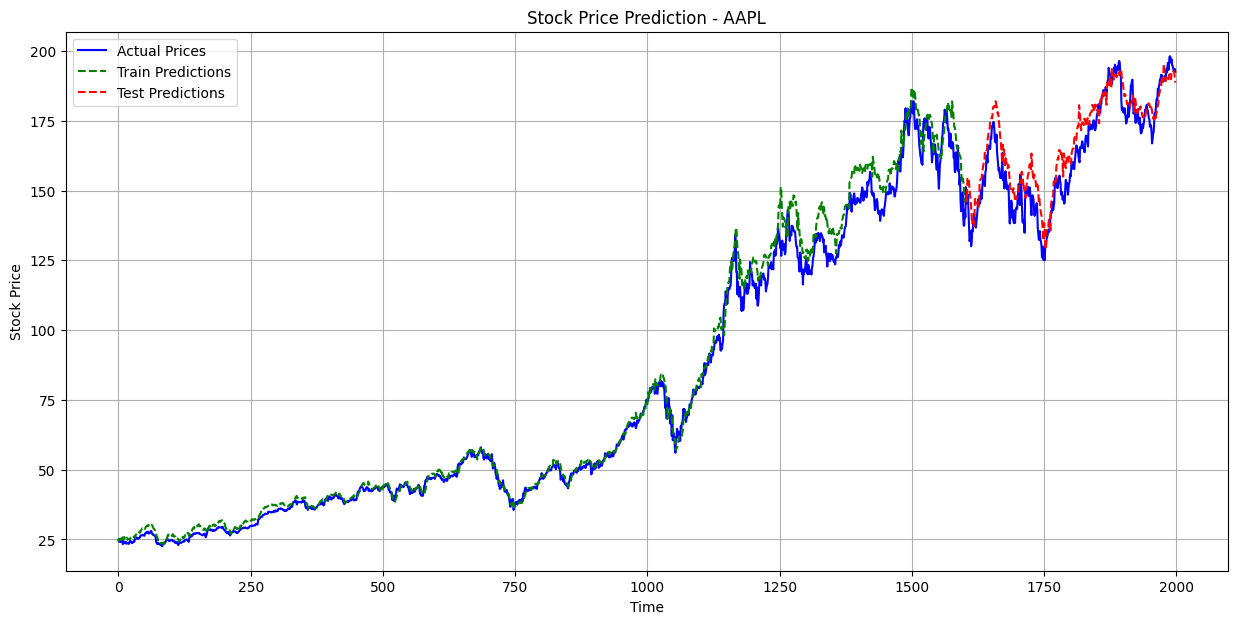

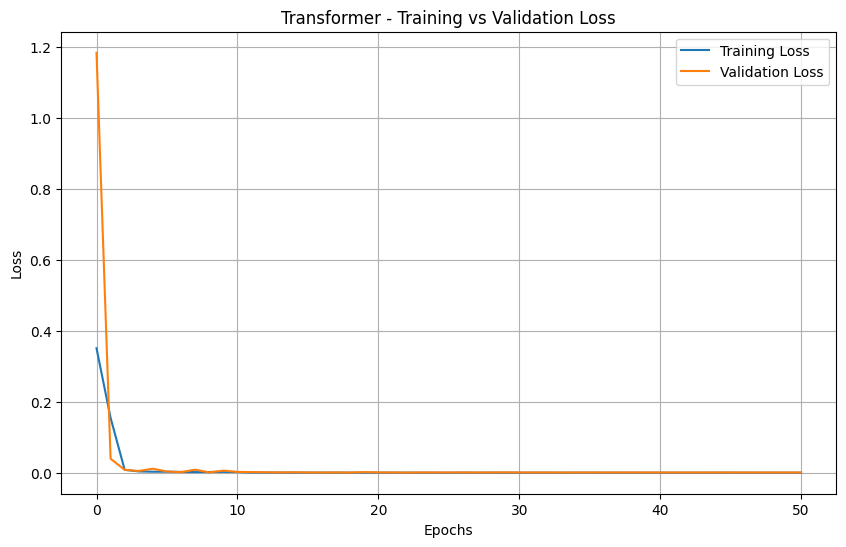


************************************** TRAINING WITH FX32 PRECISION **************************************

Using device: mps

Epoch 0/50, Training Loss: 1.4921590053, Validation Loss: 3.3702045508
Epoch 1/50, Training Loss: 0.4858960089, Validation Loss: 0.3699389177
Epoch 2/50, Training Loss: 0.1096476943, Validation Loss: 0.2511300776
Epoch 3/50, Training Loss: 0.0515404440, Validation Loss: 0.1572788176
Epoch 4/50, Training Loss: 0.0204341856, Validation Loss: 0.0383430328
Epoch 5/50, Training Loss: 0.0094180033, Validation Loss: 0.0254523944
Epoch 6/50, Training Loss: 0.0086506339, Validation Loss: 0.0279492389
Epoch 7/50, Training Loss: 0.0074504392, Validation Loss: 0.0271033115
Epoch 8/50, Training Loss: 0.0070031721, Validation Loss: 0.0304492425
Epoch 9/50, Training Loss: 0.0066661353, Validation Loss: 0.0282185943
Epoch 10/50, Training Loss: 0.0058709520, Validation Loss: 0.0227199953
Epoch 11/50, Training Loss: 0.0052152622, Validation Loss: 0.0248262146
Epoch 12/50, Train

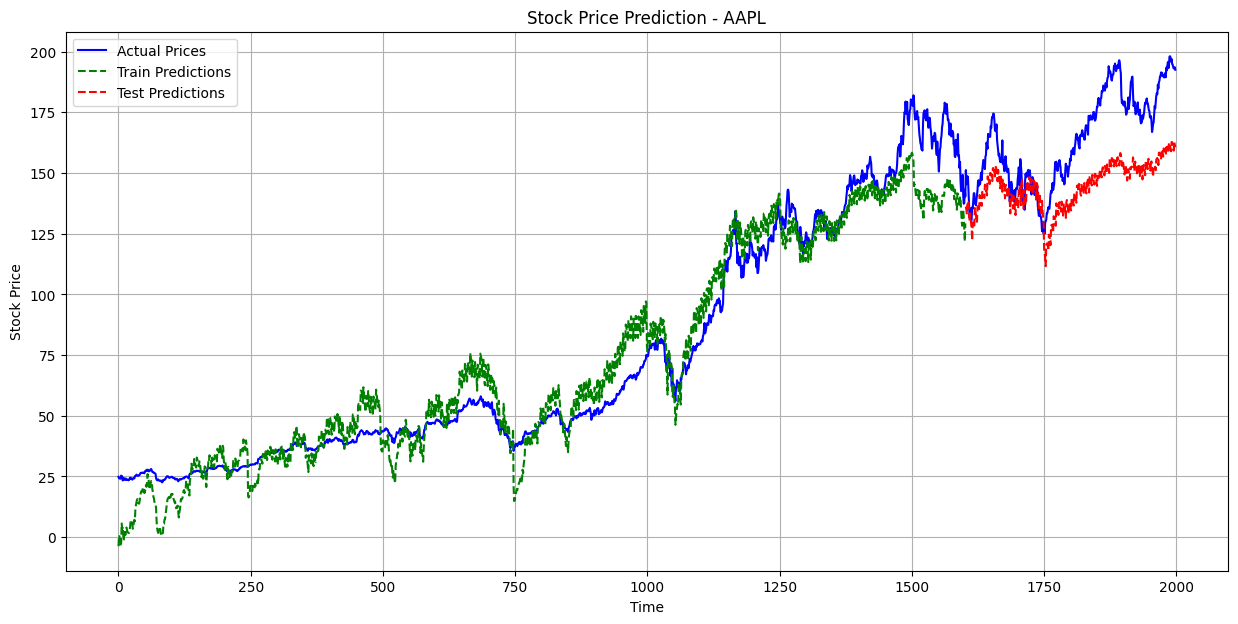

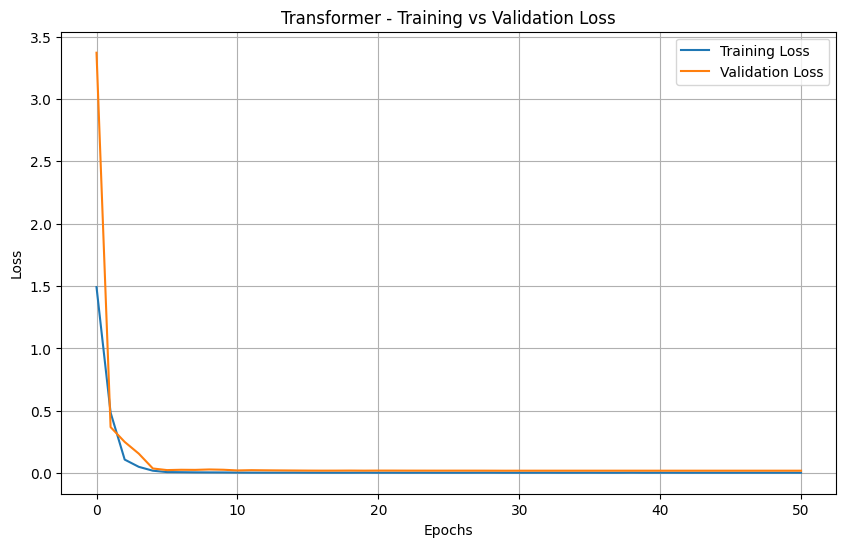


************************************** TRAINING WITH FX16 PRECISION **************************************

Using device: mps

Epoch 0/50, Training Loss: 0.3434414132, Validation Loss: 1.0037903101
Epoch 1/50, Training Loss: 0.1561826386, Validation Loss: 0.4255737021
Epoch 2/50, Training Loss: 0.0938644927, Validation Loss: 0.3266517918
Epoch 3/50, Training Loss: 0.0745752510, Validation Loss: 0.3515830004
Epoch 4/50, Training Loss: 0.0792877503, Validation Loss: 0.3335116192
Epoch 5/50, Training Loss: 0.0553561105, Validation Loss: 0.1739436823
Epoch 6/50, Training Loss: 0.0232874490, Validation Loss: 0.0659183279
Epoch 7/50, Training Loss: 0.0137662233, Validation Loss: 0.0509273928
Epoch 8/50, Training Loss: 0.0137820338, Validation Loss: 0.0543346399
Epoch 9/50, Training Loss: 0.0145581670, Validation Loss: 0.0495726330
Epoch 10/50, Training Loss: 0.0145057258, Validation Loss: 0.0482403696
Epoch 11/50, Training Loss: 0.0146871419, Validation Loss: 0.0523816652
Epoch 12/50, Train

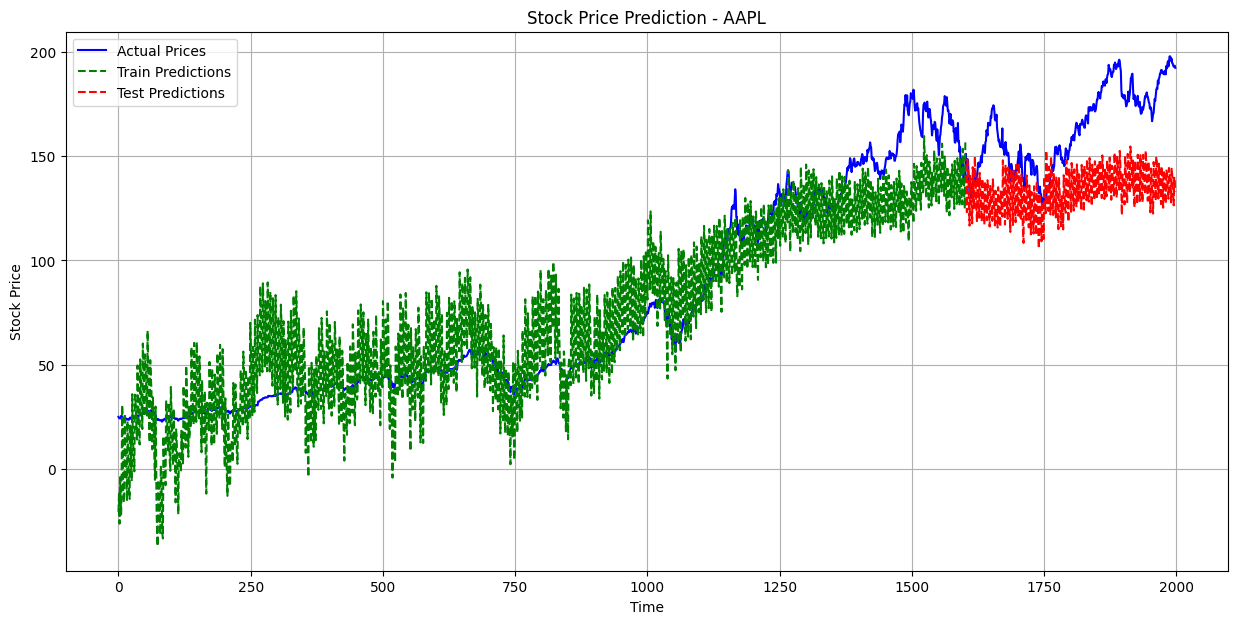

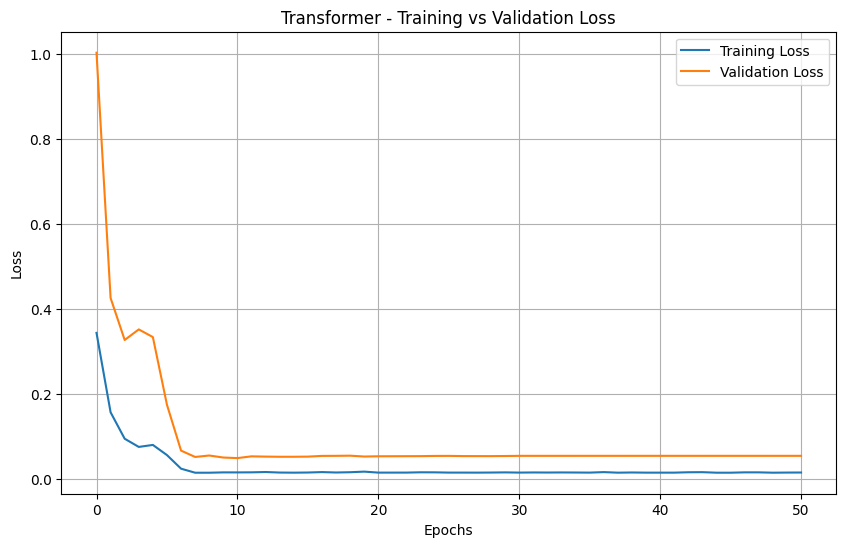


************************************** TRAINING WITH FX8 PRECISION **************************************

Using device: mps

Epoch 0/50, Training Loss: 0.3261298679, Validation Loss: 0.1354957471
Epoch 1/50, Training Loss: 0.1387480656, Validation Loss: 0.1300846834
Epoch 2/50, Training Loss: 0.0916762525, Validation Loss: 0.2436228759
Epoch 3/50, Training Loss: 0.0727418383, Validation Loss: 0.2420700539
Epoch 4/50, Training Loss: 0.0644095727, Validation Loss: 0.2298557764
Epoch 5/50, Training Loss: 0.0569213376, Validation Loss: 0.2065425676
Epoch 6/50, Training Loss: 0.0420495766, Validation Loss: 0.0947162510
Epoch 7/50, Training Loss: 0.0288585040, Validation Loss: 0.0866320217
Epoch 8/50, Training Loss: 0.0297485071, Validation Loss: 0.0681979431
Epoch 9/50, Training Loss: 0.0280515629, Validation Loss: 0.0579659547
Epoch 10/50, Training Loss: 0.0271400744, Validation Loss: 0.0544738360
Epoch 11/50, Training Loss: 0.0263957926, Validation Loss: 0.0531168917
Epoch 12/50, Traini

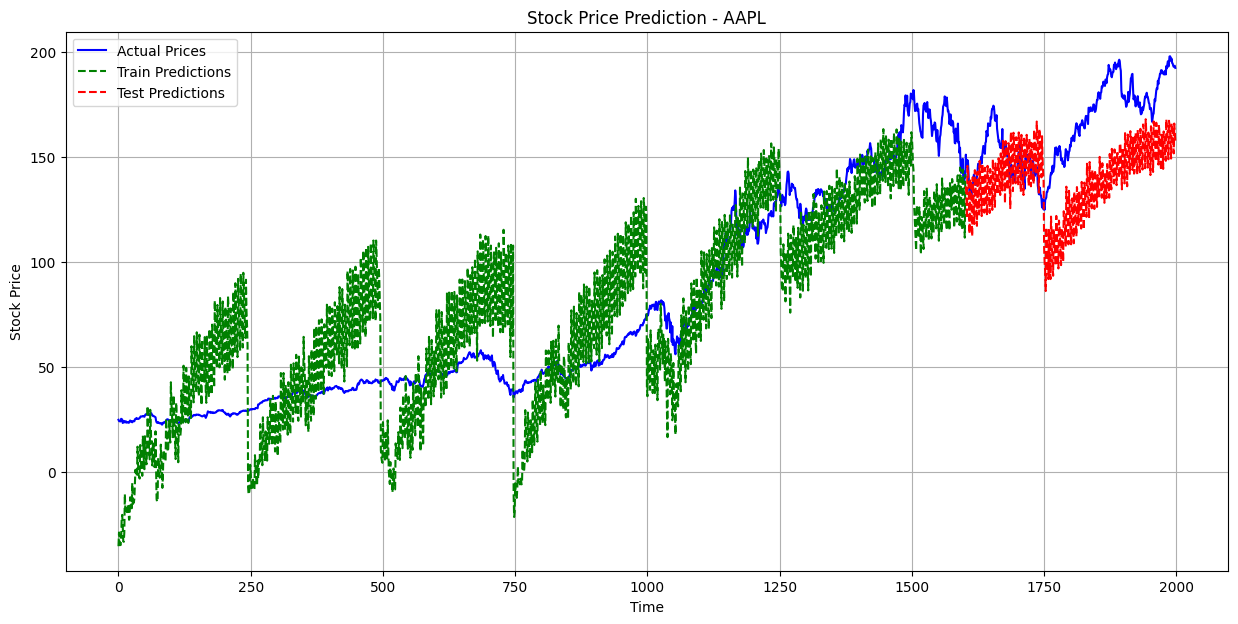

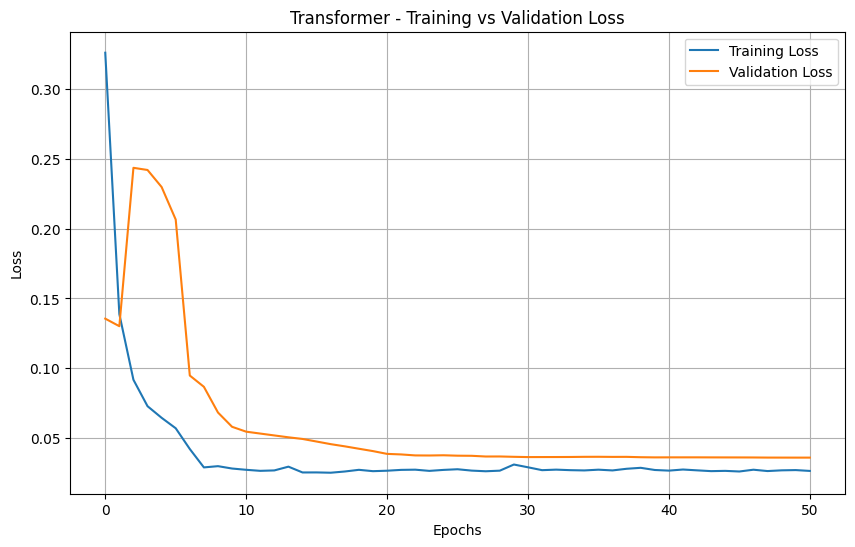


************************************** TRAINING WITH FX4 PRECISION **************************************

Using device: mps

Epoch 0/50, Training Loss: 0.1118967421, Validation Loss: 0.0681589485
Epoch 1/50, Training Loss: 0.1349990282, Validation Loss: 0.0412838939
Epoch 2/50, Training Loss: 0.1105352359, Validation Loss: 0.0234148750
Epoch 3/50, Training Loss: 0.1060770028, Validation Loss: 0.0292797050
Epoch 4/50, Training Loss: 0.1391152556, Validation Loss: 0.0262827502
Epoch 5/50, Training Loss: 0.1940922064, Validation Loss: 0.0375807769
Epoch 6/50, Training Loss: 0.2286313449, Validation Loss: 0.0846057971
Epoch 7/50, Training Loss: 0.2322586687, Validation Loss: 0.0933971270
Epoch 8/50, Training Loss: 0.2332118351, Validation Loss: 0.0689390030
Epoch 9/50, Training Loss: 0.2250738120, Validation Loss: 0.0542572457
Epoch 10/50, Training Loss: 0.1988780192, Validation Loss: 0.0470300677
Epoch 11/50, Training Loss: 0.1885976696, Validation Loss: 0.0436641475
Epoch 12/50, Traini

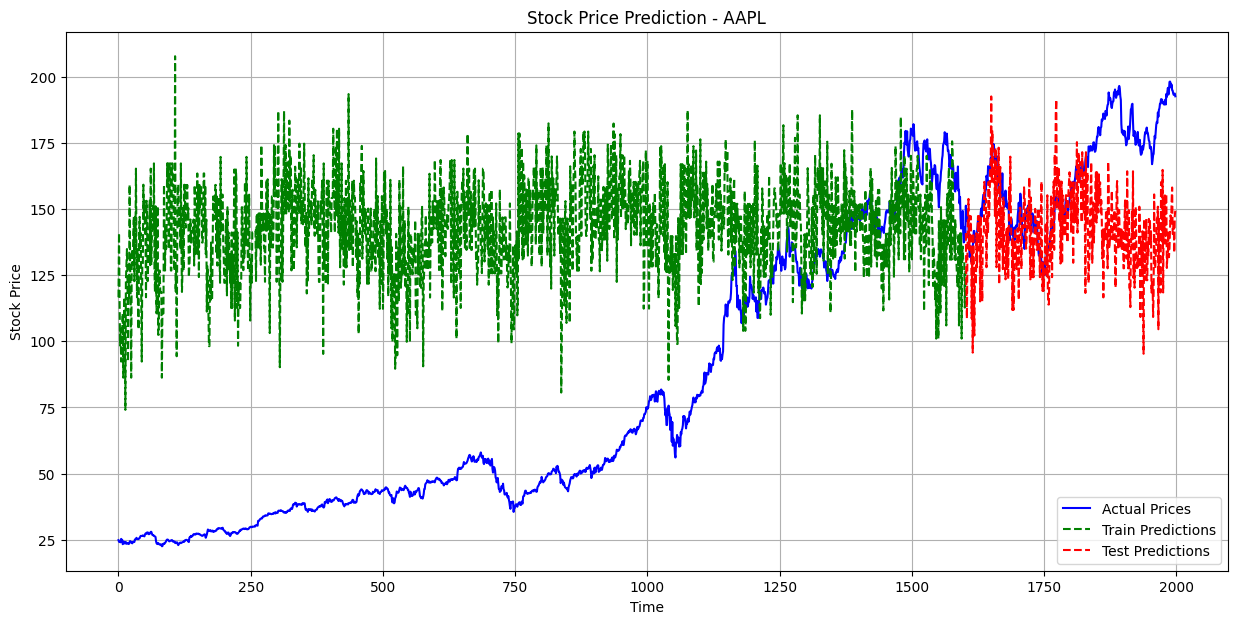

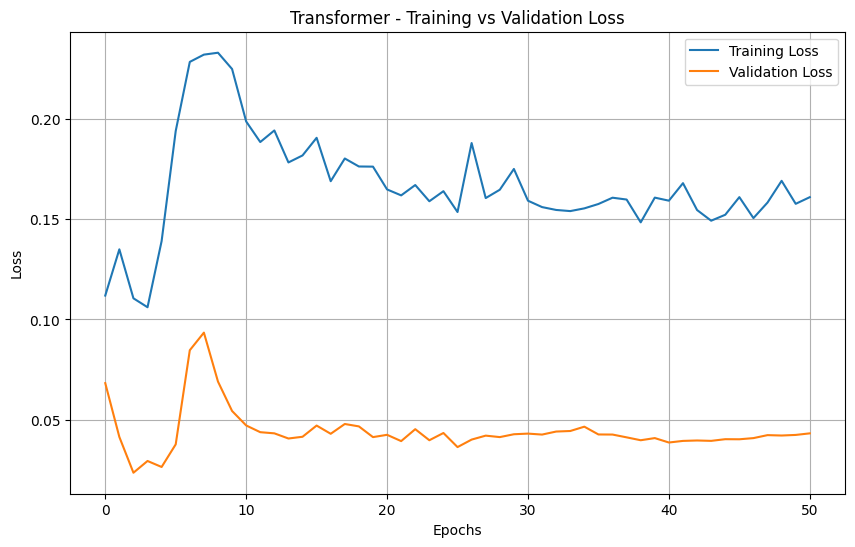


************************************** TRAINING WITH BinarizeWeights PRECISION **************************************

Using device: mps

Epoch 0/50, Training Loss: 55.8992028397, Validation Loss: 77.8018875699
Epoch 1/50, Training Loss: 84.6672863145, Validation Loss: 25.7034149554
Epoch 2/50, Training Loss: 57.3027735411, Validation Loss: 5.2285183539
Epoch 3/50, Training Loss: 37.5873653255, Validation Loss: 1.7842838950
Epoch 4/50, Training Loss: 40.4784150427, Validation Loss: 2.1048489626
Epoch 5/50, Training Loss: 39.0325773813, Validation Loss: 0.9630542606
Epoch 6/50, Training Loss: 39.4075311287, Validation Loss: 1.8416122609
Epoch 7/50, Training Loss: 39.6163087766, Validation Loss: 2.3219272220
Epoch 8/50, Training Loss: 38.9536375124, Validation Loss: 2.6023250935
Epoch 9/50, Training Loss: 32.7441318050, Validation Loss: 1.6629475322
Epoch 10/50, Training Loss: 35.1764800682, Validation Loss: 2.1248872118
Epoch 11/50, Training Loss: 31.0961290471, Validation Loss: 2.5093

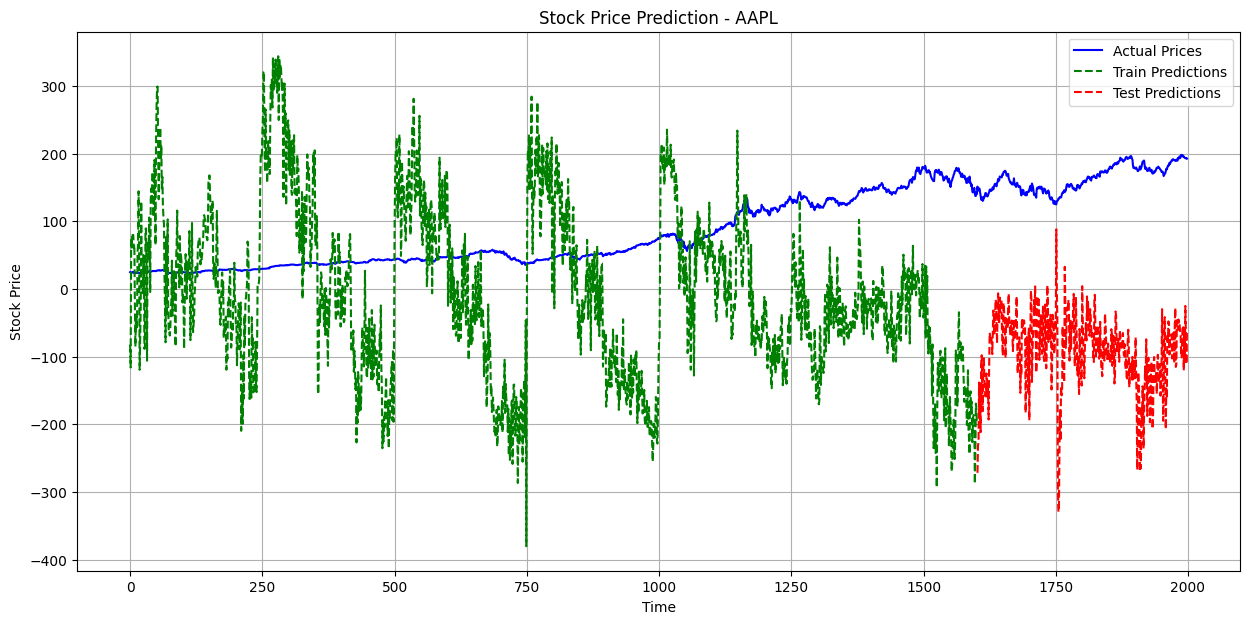

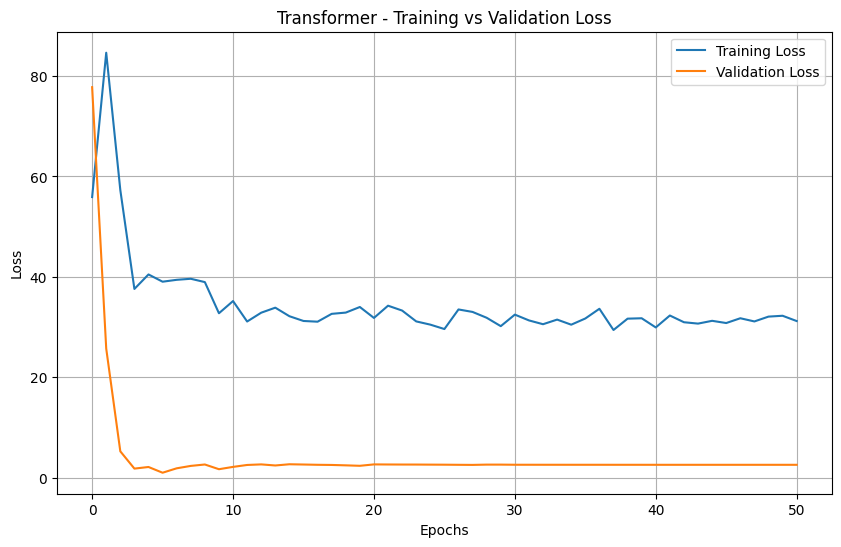

In [12]:
# Launching training for various quantization
# 1. FP32 
# 2. FX32
# 3. FX16
# 4. FX8
# 5. FX4
# 6. Binarizing Weights
for activation_bits, weight_bits in [(None, None), (32,32), (16,16), (8,8), (4,4), (None, 1)]:
  model_analysis(activation_bits=activation_bits,
                 weight_bits=weight_bits,
                 load_pretrained_model=load_pretrained_model,
                 epochs=epochs,
                 batch_size=batch_size,
                 lr=learning_rate)

## FP16 Quantization using torch.amp library

### Model

In [13]:
class CustomMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super(CustomMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        # Linear layers for queries, keys, and values
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        batch_size, seq_len, embed_dim = query.size()

        # Project queries, keys, and values
        Q = self.q_proj(query)  # (batch_size, seq_len, embed_dim)
        K = self.k_proj(key)    # (batch_size, seq_len, embed_dim)
        V = self.v_proj(value)  # (batch_size, seq_len, embed_dim)

        # Split into multiple heads and reshape
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)
        attn_probs = F.softmax(attn_scores, dim=-1)  # Apply softmax
        attn_probs = self.dropout(attn_probs)  # Apply dropout

        # Attention output
        attn_output = torch.matmul(attn_probs, V)  # (batch_size, num_heads, seq_len, head_dim)

        # Concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)  # (batch_size, seq_len, embed_dim)
        output = self.out_proj(attn_output)  # Final linear projection
        return output


class TransformerStockPredictor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, seq_len):
        super(TransformerStockPredictor, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len

        # Input layer
        self.input_layer = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, d_model))

        # Transformer encoder components
        self.self_attention_layers = nn.ModuleList([
            CustomMultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
            for _ in range(num_encoder_layers)
        ])
        self.layer_norm1 = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_encoder_layers)])
        self.feedforward1 = nn.ModuleList([nn.Linear(d_model, dim_feedforward) for _ in range(num_encoder_layers)])
        self.activation = nn.ModuleList([nn.ReLU() for _ in range(num_encoder_layers)])
        self.feedforward2 = nn.ModuleList([nn.Linear(dim_feedforward, d_model) for _ in range(num_encoder_layers)])
        self.layer_norm2 = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_encoder_layers)])
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for _ in range(num_encoder_layers)])

        # Output layer
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # Input layer
        x = self.input_layer(x) + self.positional_encoding  # Add positional encoding

        # Transformer encoder
        for i in range(len(self.self_attention_layers)):
            # Self-attention layer
            attn_output = self.self_attention_layers[i](x, x, x)  # Multihead attention
            x = x + self.dropout[i](attn_output)  # Residual connection
            x = self.layer_norm1[i](x)  # Layer normalization

            # Feedforward layer
            ff_output = self.feedforward1[i](x)  # First linear layer
            ff_output = self.activation[i](ff_output)  # Activation
            ff_output = self.feedforward2[i](ff_output)  # Second linear layer
            x = x + self.dropout[i](ff_output)  # Residual connection
            x = self.layer_norm2[i](x)  # Layer normalization

        # Output layer
        x = x[:, -1, :]  # Take the output corresponding to the last sequence element
        return self.output_layer(x)

### Training and Inference Function

In [ ]:
def training_fp16(model, train_X, train_Y, test_X, test_Y, epochs=50, batch_size=32, lr=0.001, device=torch.device("cpu")):
    # Loss function, optimizer, scheduler
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Move model to device
    model.to(device)

    # Move data to device
    train_X, train_Y = train_X.to(device), train_Y.to(device)
    test_X, test_Y = test_X.to(device), test_Y.to(device)

    # For mixed precision training
    scaler = GradScaler(device.type)

    training_loss = []
    validation_loss = []

    # Calculate and log losses at epoch 0
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
       with autocast(device.type):
          # Training loss
          train_epoch_loss = 0
          for i in range(0, train_X.size(0), batch_size):
              batch_X = train_X[i:i + batch_size]
              batch_Y = train_Y[i:i + batch_size]
              outputs = model(batch_X)
              loss = criterion(outputs.squeeze(), batch_Y.squeeze())
              train_epoch_loss += loss.item()
          train_epoch_loss /=  (len(test_X) / batch_size)

          # Validation loss
          val_epoch_loss = 0
          for i in range(0, test_X.size(0), batch_size):
              batch_X = test_X[i:i+batch_size]
              batch_Y = test_Y[i:i+batch_size]
              outputs = model(batch_X)
              loss = criterion(outputs.squeeze(), batch_Y.squeeze())
              val_epoch_loss += loss.item()
          val_epoch_loss /=  (len(test_X) / batch_size)

    training_loss.append(train_epoch_loss)
    validation_loss.append(val_epoch_loss)

    print(f"Epoch 0/{epochs}, Training Loss: {train_epoch_loss:.10f}, Validation Loss: {val_epoch_loss:.10f}")

    # Training loop
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0)).to(device)
        train_epoch_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_Y = train_X[indices], train_Y[indices]
            optimizer.zero_grad()

            # Forward and backward passes with mixed precision
            with autocast(device.type):
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_Y.squeeze())

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            train_epoch_loss += loss.item()

        train_epoch_loss /= len(train_X) / batch_size  # Normalize epoch loss
        scheduler.step()

        # Validation loss
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            with autocast(device.type):
                for i in range(0, test_X.size(0), batch_size):
                    batch_X = test_X[i:i+batch_size]
                    batch_Y = test_Y[i:i+batch_size]
                    outputs = model(batch_X)
                    loss = criterion(outputs.squeeze(), batch_Y.squeeze())
                    val_epoch_loss += loss.item()
        val_epoch_loss /=  (len(test_X) / batch_size)

        training_loss.append(train_epoch_loss)
        validation_loss.append(val_epoch_loss)


        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_epoch_loss:.10f}, Validation Loss: {val_epoch_loss:.10f}")

    model.cpu()

    return {'training_loss': training_loss, 'validation_loss': validation_loss}

def inference_fp16(model, data_loader):
    """
    Function to predict outputs using the trained model in FP16 precision.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset (training or test).
        device: Device to run the model on (CPU/GPU).

    Returns:
        predictions: List of predicted values.
        true_values: List of actual values (ground truth).
    """
    model.eval()
    predictions, true_values = [], []

    # Use autocast for FP16 inference
    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch, Y_batch = X_batch, Y_batch
            with autocast(device.type):
                preds = model(X_batch)
            predictions.extend(preds.numpy())
            true_values.extend(Y_batch.numpy())

    return np.array(predictions), np.array(true_values)

### Execution


Using device: cpu
Epoch 0/50, Training Loss: 3.6723977195, Validation Loss: 2.8912132897
Epoch 1/50, Training Loss: 0.3806451683, Validation Loss: 0.4746585361
Epoch 2/50, Training Loss: 0.0823503643, Validation Loss: 0.2635502635
Epoch 3/50, Training Loss: 0.0569407525, Validation Loss: 0.1402065604
Epoch 4/50, Training Loss: 0.0131624780, Validation Loss: 0.0611211866
Epoch 5/50, Training Loss: 0.0095920325, Validation Loss: 0.0556335614
Epoch 6/50, Training Loss: 0.0083831685, Validation Loss: 0.0438833902
Epoch 7/50, Training Loss: 0.0063475858, Validation Loss: 0.0321895012
Epoch 8/50, Training Loss: 0.0061454644, Validation Loss: 0.0274461997
Epoch 9/50, Training Loss: 0.0061728249, Validation Loss: 0.0443772156
Epoch 10/50, Training Loss: 0.0069842369, Validation Loss: 0.0575408042
Epoch 11/50, Training Loss: 0.0069617222, Validation Loss: 0.0571124861
Epoch 12/50, Training Loss: 0.0068502859, Validation Loss: 0.0525400953
Epoch 13/50, Training Loss: 0.0066390692, Validation Lo

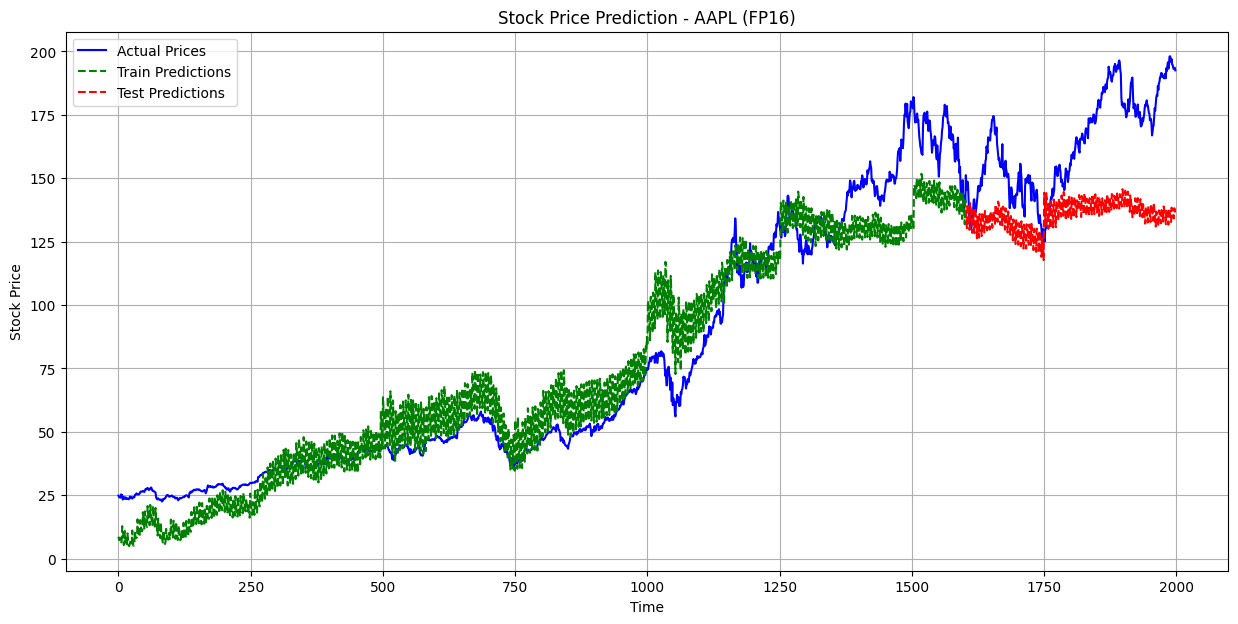

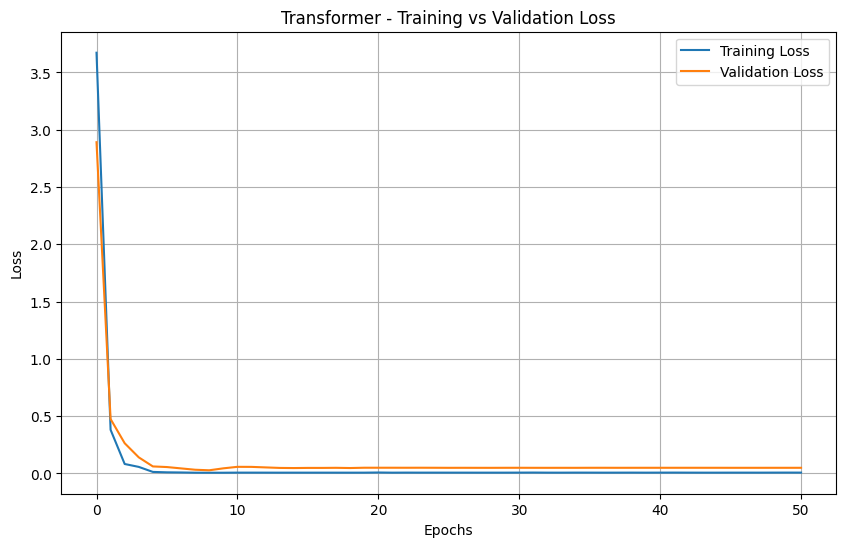

In [21]:
# Training Configuration
load_pretrained_model = False
precision = 'FP16'
epochs = 50
learning_rate = 0.001
batch_size = 64

# Path to save/load model info
model_path = f"trained_models/sp_{ticker}_{precision}_epoch{epochs}.pth"
loss_tracker_path = f"trained_models/sp_{ticker}_{precision}_epoch{epochs}.pkl"

# Load and preprocess data
(train_X,
train_Y,
test_X,
test_Y,
feature_scaler,
target_scaler) = load_data_with_indicators(data_path,
                                           column='Close',
                                           time_step=time_step,
                                           train_fraction=train_fraction)

# Create Model
model_fp16 = QuantizedTransformerStockPredictor(input_dim=train_X.shape[-1],
                                                d_model=dmodel, nhead=nhead,
                                                num_encoder_layers=num_encoder_layers,
                                                dim_feedforward=dim_feedforward,
                                                dropout=drop_out,
                                                seq_len=time_step)

################################################################################
# Perform Training
################################################################################
if load_pretrained_model is False:

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"\nUsing device: {device}")

  # Move the model to device
  model_fp16 = model_fp16.to(device)

  # Perform Training
  loss_tracker_fp16 = training_fp16(model_fp16,
                                    train_X,
                                    train_Y,
                                    test_X,
                                    test_Y,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    lr=learning_rate,
                                    device=device)

  # Move the model back to CPU
  model_fp16.cpu()

  # Save the model state
  torch.save(model_fp16.state_dict(), model_path)
  print(f"Model saved to {model_path}")

  # Save the loss tracker dictionary
  with open(loss_tracker_path, 'wb') as f:
      pickle.dump(loss_tracker_fp16, f)
  print(f"Loss tracker saved to {loss_tracker_path}")

################################################################################
# Load Pretrained Model
################################################################################
else:

  # Load the saved state_dict into the model
  model_fp16.load_state_dict(torch.load(model_path, weights_only=False))
  print(f"Model loaded successfully from {model_path}")

  # Load the loss tracker dictionary
  with open(loss_tracker_path, 'rb') as f:
      loss_tracker_fp16 = pickle.load(f)
  print(f"Loss tracker loaded successfully from {loss_tracker_path}")
  
################################################################################ 
# # Stock Price Actual vs Predicted Plot    
################################################################################
  
plot_stock_prediction(model_fp16, train_X, train_Y, test_X, test_Y, batch_size, target_scaler, f'{ticker} ({precision})')
  
################################################################################
# Loss Convergence Plot
################################################################################
  
plot_loss(loss_tracker_fp16['training_loss'], loss_tracker_fp16['validation_loss'], epochs=epochs, model_name="Transformer")